# importieren wichtige Pakete

In [232]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import make_scorer
from numpy.polynomial.polynomial import Polynomial

pd.set_option('display.max_columns', 500)
# für Visualisierung

#plt.rcParams.keys()
plt.rcParams['ytick.labelsize'] = "large"
plt.rcParams['xtick.labelsize'] = "large"
plt.rcParams['axes.labelsize'] = "large"
plt.rcParams['figure.titlesize'] = "x-large"


import warnings
warnings.filterwarnings("ignore")


## Daten lesen und visualisieren

### Load the data and compute RUL

In [233]:
# Laden die Daten FD001 als Beispiel
def read_data(file_name):
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["Operation Setting "+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["Sensor Measure"+str(i) for i in range(1,22)]
    
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    
    data = pd.read_csv(file_name, delim_whitespace=True, header=None)
    print("Größe der Daten : Rows {}, Columns {}".format(data.shape[0], data.shape[1]))
    data.columns = input_file_column_names
    return data

In [234]:
def calculate_rul_and_remove_operational (df):
    df['rul'] = df.groupby('UnitNumber')['Cycle'].transform(lambda x: x.max() - x)
    df['rul'] = df['rul'].apply(lambda x: min(x, 130))
    df.drop(['Operation Setting 1','Operation Setting 2','Operation Setting 3', 'Cycle'], axis=1, inplace=True)
    return df

In [235]:
train_data = read_data('./data/train_FD001.txt')
train_data = calculate_rul_and_remove_operational(train_data)
train_data.head()

Größe der Daten : Rows 20631, Columns 26


,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,130
1,1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,130
2,1,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,130
3,1,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,130
4,1,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,130


## Schritt 1: Daten Normalisierung und Glättung 

### Entferne Spalten mit konstantem Werten

In [236]:
def identify_and_remove_unique_columns(Dataframe):
    unique_counts = Dataframe.nunique()
    # identify columns with only one unique value and drop them (constant values)
    record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
    to_drop = list(record_single_unique['feature'])
    Dataframe = Dataframe.drop(columns = to_drop)
    return Dataframe

In [237]:
print("Größe vor der Verarbeitung ", train_data.shape)

train_data_relevant = identify_and_remove_unique_columns(train_data)
print("Größe Nach der Verarbeitung", train_data_relevant.shape)

sensor_columns = [col for col in train_data_relevant.columns if 'Sensor Measure' in col]
train_data_relevant.head()

Größe vor der Verarbeitung  (20631, 23)
Größe Nach der Verarbeitung (20631, 17)


,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,130
1,1,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,130
2,1,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,130
3,1,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,130
4,1,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,130


### Daten Normalisieren mit Z-Score

In [238]:
scaler = StandardScaler()

normalized_train_data = train_data_relevant.copy()
# Normalisierung der Sensormessungeen
normalized_train_data = train_data_relevant.copy()
normalized_train_data[sensor_columns] =  scaler.fit_transform(normalized_train_data[sensor_columns])
normalized_train_data.head()

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,-1.721725,-0.134255,-0.925936,0.141683,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427,130
1,1,-1.061780,0.211528,-0.643726,0.141683,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922,130
2,1,-0.661813,-0.413166,-0.525953,0.141683,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423,130
3,1,-0.661813,-1.261314,-0.784831,0.141683,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792,130
4,1,-0.621816,-1.251528,-0.301518,0.141683,0.714393,-0.516338,-0.457059,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552,130


### Polynomial fitting

In [239]:
def fit_polynomial(df, degree=3, col_name_unit_number='UnitNumber'):
    def poly_fit(df, degree):
        # This inner function fits a polynomial to each column, returning the fitted values and coefficients.
        fitted_values = {}
        coeffs = {}
        for col in df.columns:
            poly = Polynomial.fit(range(len(df[col])), df[col], degree)
            fitted_values[col] = poly(range(len(df[col])))
            coeffs[col] = poly.coef
        return pd.DataFrame(fitted_values, index=df.index), coeffs
    
    sensor_columns = df.columns.difference([col_name_unit_number])  # Exclude the unit number column
    all_fitted = []
    all_coeffs = {}
    
    for unit in df[col_name_unit_number].unique():
        unit_data = df.loc[df[col_name_unit_number] == unit, sensor_columns]
        fitted_data, coeffs = poly_fit(unit_data, degree)
        all_fitted.append(df.loc[df[col_name_unit_number] == unit].assign(**fitted_data))
        all_coeffs[unit] = coeffs

    return pd.concat(all_fitted, ignore_index=True), all_coeffs


In [240]:
polynomial_train_data = normalized_train_data.copy()
polynomial_train_data[sensor_columns + ['UnitNumber']], polynomials = fit_polynomial(normalized_train_data[sensor_columns + ['UnitNumber']])
polynomial_train_data.head()

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,-0.798512,-0.466045,-0.983026,0.141683,0.930287,-0.569979,-0.687156,-1.111285,0.870001,-0.773328,-0.552246,-0.970137,-0.896622,1.015534,1.062681,130
1,1,-0.794304,-0.472907,-0.980079,0.141683,0.925949,-0.566511,-0.686939,-1.100674,0.870436,-0.766315,-0.555730,-0.956198,-0.892935,1.001607,1.051339,130
2,1,-0.790239,-0.479704,-0.977208,0.141683,0.921728,-0.563196,-0.686718,-1.090309,0.870859,-0.759472,-0.559093,-0.942654,-0.889361,0.988028,1.040274,130
3,1,-0.786313,-0.486435,-0.974409,0.141683,0.917621,-0.560029,-0.686495,-1.080185,0.871266,-0.752793,-0.562339,-0.929500,-0.885896,0.974791,1.029482,130
4,1,-0.782522,-0.493098,-0.971679,0.141683,0.913625,-0.557005,-0.686270,-1.070297,0.871655,-0.746275,-0.565470,-0.916729,-0.882537,0.961891,1.018957,130


## Schritt 2: Feature-Auswahl mit Lasso-Regression

In [241]:
def lasso_feature_selection(X, y, alpha=2.7):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    return np.array(X.columns)[lasso.coef_ != 0]

In [242]:
selected_features = lasso_feature_selection(polynomial_train_data[sensor_columns], polynomial_train_data['rul'])
selected_features

array(['Sensor Measure4', 'Sensor Measure9', 'Sensor Measure11'],
      dtype=object)

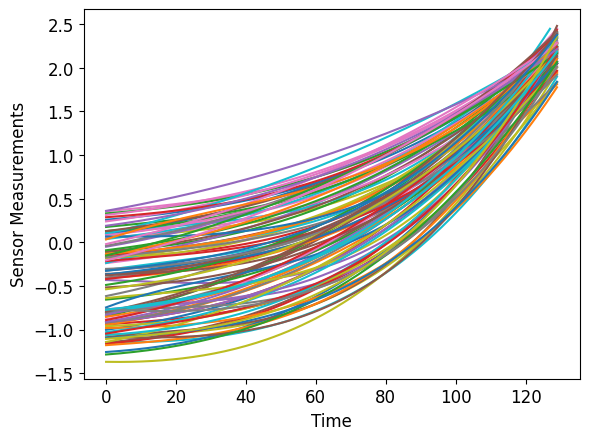

In [243]:
# visualize the smoothed data for unit 1 for each sensor separately
for i in range(101):
    poldata = polynomial_train_data[polynomial_train_data['rul']<130]   
    poly = poldata[poldata['UnitNumber'] == i]['Sensor Measure4']
    plt.plot(range(len(poly)), poly, label='Sensor Measure2_smoothed')
        
plt.xlabel('Time')
plt.ylabel('Sensor Measurements')

plt.show()

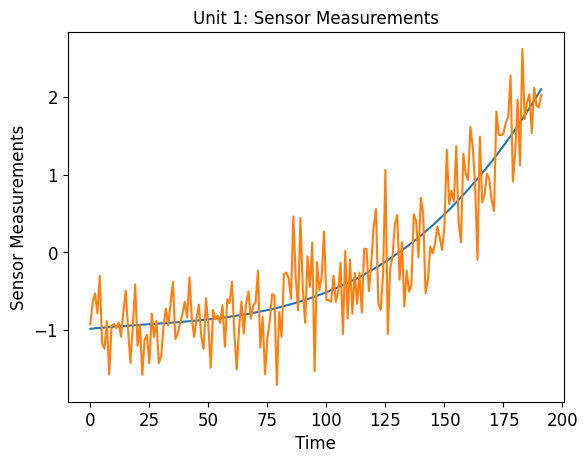

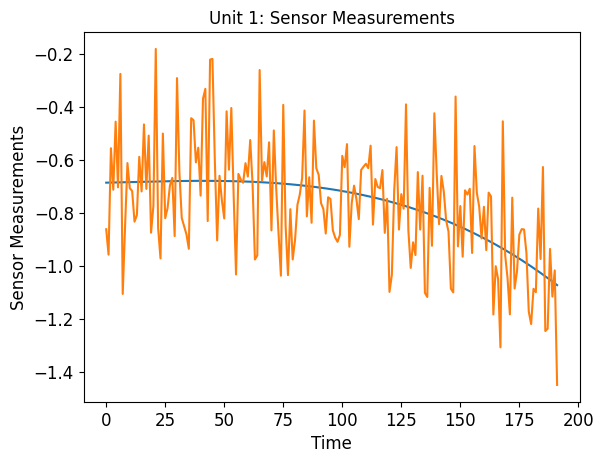

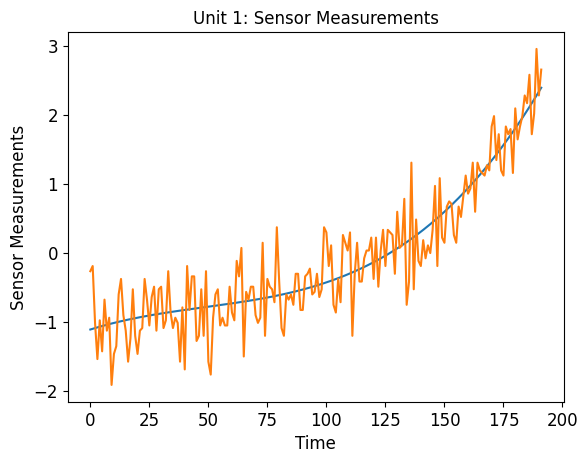

In [244]:
# visualize the unsmoothed and smmothed data for unit 1 for each sensor separately
for col in selected_features:
    plt.plot(polynomial_train_data[polynomial_train_data['UnitNumber'] == 1][col], label=col)
    plt.plot(normalized_train_data[normalized_train_data['UnitNumber'] == 1][col], label=col+'_original')
        
    plt.title('Unit 1: Sensor Measurements')
    plt.xlabel('Time')
    plt.ylabel('Sensor Measurements')
    plt.show()

### Schritt 3: Feature-Extraktion 

In [245]:
selected_polynomial_train_data = polynomial_train_data[[ 'UnitNumber', 'rul']+list(selected_features)]

In [246]:
selected_polynomial_train_data[selected_polynomial_train_data['UnitNumber'] == 1]

,UnitNumber,rul,Sensor Measure4,Sensor Measure9,Sensor Measure11
0,1,130,-0.983026,-0.687156,-1.111285
1,1,130,-0.980079,-0.686939,-1.100674
2,1,130,-0.977208,-0.686718,-1.090309
3,1,130,-0.974409,-0.686495,-1.080185
4,1,130,-0.971679,-0.686270,-1.070297
...,...,...,...,...,...
187,1,4,1.906979,-1.046916,2.167012
188,1,3,1.955072,-1.053479,2.222019
189,1,2,2.003728,-1.060119,2.277751
190,1,1,2.052949,-1.066836,2.334216


In [247]:
def extract_features(df, window_length=20, stride=20):
    features = []
    targets = []
    unit_numbers = []
    column_names = [col for col in df.columns if 'Sensor Measure' in col]
    for unit in df['UnitNumber'].unique():
        unit_df = df[df['UnitNumber'] == unit]
        for start in range(len(unit_df) - window_length,0, -stride):
            end = start + window_length 
            window = unit_df.iloc[start:end]

            feature_vector = []
            
            for sensor in column_names:
                mean_val = window[sensor].mean()
                trend = np.polyfit(range(window_length), window[sensor], 1)[0]
                feature_vector.extend([mean_val, trend])
                
                #plt.plot(window[sensor])
                #plt.scatter(start+10, mean_val, color='red', label='Mean Value')
               
            features.append(feature_vector)
            unit_numbers.extend([unit])
            targets.append(unit_df.iloc[end-1]['rul'])
            
    cols = []
    for sensor in column_names:
        cols.extend([sensor + '_mean', sensor + '_trend'])
    return_df = pd.DataFrame(data=np.array(features), columns=cols)
    return_df['UnitNumber'] = unit_numbers
    return return_df, pd.DataFrame(targets, columns=['rul'])

In [248]:
x_train , y_train = extract_features(selected_polynomial_train_data[selected_polynomial_train_data['UnitNumber'] == 1])
x_train.head()

,Sensor Measure4_mean,Sensor Measure4_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber
0,1.661341,0.044825,-1.013371,-0.006121,1.888744,0.050809,1
1,0.867834,0.034707,-0.904978,-0.004741,1.003459,0.037997,1
2,0.263043,0.025954,-0.822498,-0.003530,0.353596,0.027266,1
3,-0.180334,0.018566,-0.762551,-0.002487,-0.102463,0.018617,1
4,-0.489601,0.012543,-0.721758,-0.001614,-0.406336,0.012048,1


In [249]:
x_train , y_train = extract_features(selected_polynomial_train_data)
pd.concat([x_train, y_train], axis=1).head()

,Sensor Measure4_mean,Sensor Measure4_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber,rul
0,1.661341,0.044825,-1.013371,-0.006121,1.888744,0.050809,1,0.0
1,0.867834,0.034707,-0.904978,-0.004741,1.003459,0.037997,1,20.0
2,0.263043,0.025954,-0.822498,-0.003530,0.353596,0.027266,1,40.0
3,-0.180334,0.018566,-0.762551,-0.002487,-0.102463,0.018617,1,60.0
4,-0.489601,0.012543,-0.721758,-0.001614,-0.406336,0.012048,1,80.0


## Train Random Forest regressor with C-Fold Cross validation

In [250]:
def custom_score(true_rul, predicted_rul):
    scores = []
    for true, pred in zip(true_rul, predicted_rul):
        if pred < true:
            score = np.exp((true - pred) / 13) - 1
        else:
            score = np.exp((pred - true) / 10) - 1
        scores.append(score)
    mean_score = np.mean(scores)
    return mean_score

# Create the custom scorer
custom_scorer = make_scorer(custom_score, greater_is_better=False)

In [251]:
from sklearn.model_selection import GroupKFold, GridSearchCV

rf_regressor = RandomForestRegressor()
param_grid = {
    'n_estimators': range(10, 101, 10),  # Number of trees in the forest
    'max_samples': np.arange(0.3,1,0.1)  # Minimum number of samples required to be at a leaf node
}

kf = GroupKFold(n_splits=10)
grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, scoring=custom_score, n_jobs=-1)
#grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, n_jobs=-1)

grid_search.fit(x_train.drop(['UnitNumber'],axis=1).values, y_train.values.ravel(),groups= x_train['UnitNumber'].values)

best_rf_model = grid_search.best_estimator_

In [252]:
# Predicting on training data
y_train_pred = best_rf_model.predict(x_train.drop(['UnitNumber'], axis=1))
train_error = sqrt(mean_squared_error(y_train, y_train_pred))
train_error

4.273599643689796

In [253]:
best_rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': 0.9000000000000001,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 90,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Prediction

In [254]:
#Testdaten laden
test_data =read_data('./data/test_FD001.txt')
test_data = calculate_rul_and_remove_operational(test_data)
test_data.head()

Größe der Daten : Rows 13096, Columns 26


,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,30
1,1,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,29
2,1,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,28
3,1,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,27
4,1,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,26


In [255]:
constant_columns=[col for col in test_data.columns if 'Sensor Measure' in col and not col in sensor_columns]
test_data.drop(constant_columns, axis=1, inplace=True)

In [256]:
test_data[sensor_columns] = scaler.transform(test_data[sensor_columns])
test_data.head()

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,0.678077,-0.853550,-1.191480,0.141683,0.601408,-0.798093,-0.682579,-1.277396,0.415614,-0.919841,-0.954235,-0.985107,-0.781710,0.241943,0.774097,30
1,1,-1.941707,-0.338137,-1.501467,0.141683,1.674769,-1.220725,-0.490117,-0.154141,1.012195,-0.502695,-0.216648,-1.649034,-0.136018,1.127183,0.941305,29
2,1,-0.441831,-0.584426,-0.843717,0.141683,0.838677,-0.657216,-0.375093,-0.154141,0.754581,-0.919841,-0.715712,0.052112,-0.136018,1.459148,1.172256,28
3,1,-0.481827,-1.044384,-0.279297,0.141683,0.793483,-0.938970,-0.903570,-0.977861,-0.045381,-0.641744,-0.568929,-1.345067,-1.427402,1.016528,0.775945,27
4,1,-0.341839,-0.543650,-0.779276,0.141683,0.895170,-1.220725,-0.937081,-0.865536,0.998637,-0.919841,-0.745069,-1.041101,-2.073094,0.961200,1.138999,26


In [257]:
test_data[sensor_columns + ['UnitNumber']], polynomials = fit_polynomial(test_data[sensor_columns + ['UnitNumber']])
test_data.head()

,UnitNumber,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure17,Sensor Measure20,Sensor Measure21,rul
0,1,-0.395087,-0.592943,-1.187806,0.141683,0.869647,-0.937151,-0.619258,-0.638693,0.590696,-0.724179,-0.710342,-1.043017,-0.428386,0.654008,0.882367,30
1,1,-0.516792,-0.696865,-1.081140,0.141683,0.906266,-0.933912,-0.622539,-0.710473,0.622994,-0.706996,-0.679442,-1.009464,-0.617906,0.750775,0.890341,29
2,1,-0.619541,-0.783011,-0.988056,0.141683,0.934914,-0.930910,-0.628644,-0.771179,0.652708,-0.691768,-0.654848,-0.975302,-0.780161,0.835342,0.895961,28
3,1,-0.704566,-0.852584,-0.907831,0.141683,0.956196,-0.927918,-0.637232,-0.821561,0.679895,-0.678296,-0.636073,-0.940774,-0.916758,0.908260,0.899389,27
4,1,-0.773101,-0.906787,-0.839741,0.141683,0.970718,-0.924711,-0.647964,-0.862368,0.704612,-0.666381,-0.622634,-0.906121,-1.029303,0.970079,0.900788,26


In [258]:
test_data = test_data[['UnitNumber', 'rul'] + list(selected_features)].reset_index(drop=True)
test_data.head()

,UnitNumber,rul,Sensor Measure4,Sensor Measure9,Sensor Measure11
0,1,30,-1.187806,-0.619258,-0.638693
1,1,29,-1.081140,-0.622539,-0.710473
2,1,28,-0.988056,-0.628644,-0.771179
3,1,27,-0.907831,-0.637232,-0.821561
4,1,26,-0.839741,-0.647964,-0.862368


In [259]:
test_data ,  cycle_number = extract_features(test_data)
test_df = pd.concat([test_data, cycle_number], axis=1)
test_df.head()

,Sensor Measure4_mean,Sensor Measure4_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber,rul
0,-0.815628,-0.020380,-0.768992,0.008152,-0.879386,-0.000116,1,0.0
1,-0.233483,0.006847,-0.769675,-0.006136,-0.201162,0.016510,2,0.0
2,-0.378252,0.002481,-0.747352,0.004601,-0.238947,-0.004436,2,20.0
3,0.509226,0.026520,-0.672801,-0.004174,0.495329,0.019076,3,0.0
4,0.120431,0.013032,-0.603800,-0.002741,0.206696,0.010174,3,20.0


In [260]:
def online_rul_prediction(data, rf_model):
    predictions = []
    for unit in data['UnitNumber'].unique():
        unit_data = data[data['UnitNumber'] == unit]
        rul_predictions = rf_model.predict(unit_data.drop(['UnitNumber', 'rul'], axis=1))
        n = len(rul_predictions)
        rul_predictions = rul_predictions - np.array(unit_data['rul'])
        predictions.append(sum(rul_predictions) / n)
        #print("Unit: {}, Average RUL Prediction: {}".format(unit, sum(rul_predictions) / n))
    return predictions


In [261]:
RUL_FD001 = pd.read_table("./data/RUL_FD001.txt", header=None, delim_whitespace=True)
RUL_FD001

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [262]:
# Predict RUL for test data
predicted_rul = online_rul_prediction(test_df, best_rf_model)

In [263]:
print("Root mean squared error:", sqrt(mean_squared_error(RUL_FD001, predicted_rul)))
print("Custom score:", custom_score(RUL_FD001, predicted_rul))

Root mean squared error: 30.34649159338677
Custom score: 117920.89503144291


In [264]:
last = test_df.groupby('UnitNumber').max(['rul']).drop(['rul'], axis=1)
print("Root mean squared error:", sqrt(mean_squared_error(RUL_FD001, best_rf_model.predict(last))))
print("Custom score:", custom_score(RUL_FD001, predicted_rul))

Root mean squared error: 25.13912154588472
Custom score: 117920.89503144291


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


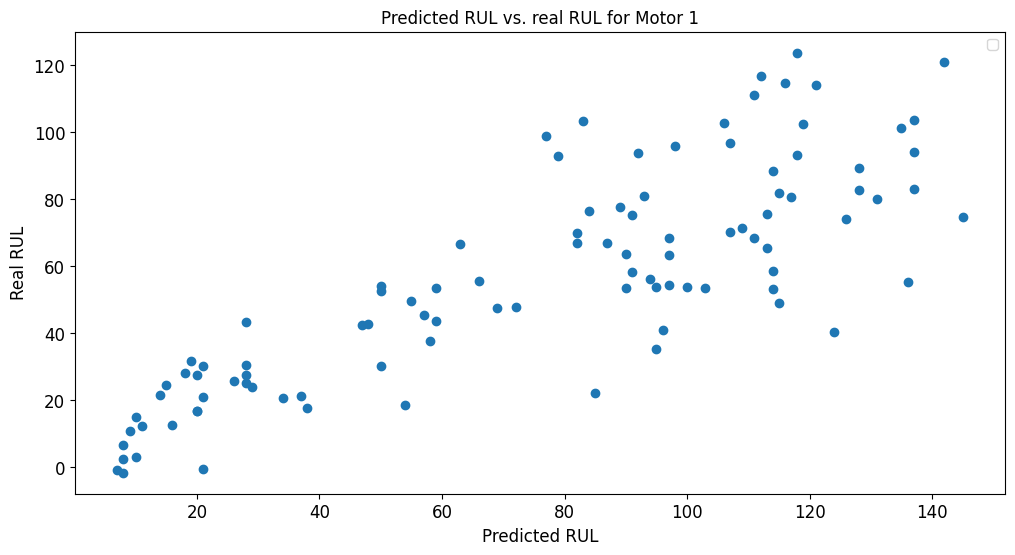

In [265]:
real_rul = pd.read_table("./data/RUL_FD001.txt", header=None, delim_whitespace=True).values

#plot the predicted RUL vs the real RUL for each data point in a scatter plot
plt.figure(figsize=(12,6))

plt.scatter(real_rul, predicted_rul)
plt.legend()
plt.title("Predicted RUL vs. real RUL for Motor 1")
plt.xlabel("Predicted RUL")
plt.ylabel("Real RUL")
plt.show()


## Build a Pipeline including the previous steps
In order to perform a gird search on the hole pipeline and find the best hyperparameters for all steps, we used the Pipeline library from scikit learn. On this pipeline we then could perform a Grid search.

### Define the pipeline for training

#### Step 1: Classes to remove constant columns, normalize the data and do polynomial fitting

In [136]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        X=X.copy()
        X = identify_and_remove_unique_columns(X)
        self.sensor_columns = [col for col in X.columns if 'Sensor Measure' in col]
        self.scaler.fit(X[self.sensor_columns])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.sensor_columns] = self.scaler.transform(X[self.sensor_columns])
        return X 

In [137]:
class PolynomialFitting(BaseEstimator, TransformerMixin):
    def __init__(self, degree=3):
        self.degree = degree

    def fit(self, X, y=None):
        self.sensor_columns = [col for col in X.columns if 'Sensor Measure' in col]
        return self

    def transform(self, X):
        X = X.copy()
        X[self.sensor_columns + ['UnitNumber']], _ = fit_polynomial(X[self.sensor_columns + ['UnitNumber']], degree=self.degree)
        return X

#### Step 2: Class to select relevant features using the Lasso regression

In [138]:
class LassoFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.7):
        self.alpha = alpha
        self.lasso = Lasso(alpha=self.alpha)

    def fit(self, X, y=None):
        x_train=X.copy().drop([ 'UnitNumber', 'rul'], axis=1)
        self.lasso.fit(x_train, X['rul'])
        self.selected_features_ =np.array(X.drop([ 'UnitNumber', 'rul'], axis=1).columns)[(self.lasso.coef_ != 0)]
        return self

    def transform(self, X):
        X=X.copy()
        X = X[[ 'UnitNumber', 'rul'] + list(self.selected_features_)]
        return X

#### Step 3: Class to extract the features using a rolling window with a certain stride

In [139]:
class FeatureExtraction(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=20, stride=20):
        self.window_size = window_size
        self.stride = stride

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        x_train , y_train = extract_features(X, self.window_size, self.stride)
        self.new_labels= y_train
        self.training_data = x_train
        return x_train#pd.concat([x_train,y_train], axis=1)

In [140]:
# Pipeline erstellen
pipeline = Pipeline([
    ('scaler', CustomScaler()),
    ('poly_fit', PolynomialFitting(degree=3)),
    ('lasso_select', LassoFeatureSelection(alpha=2.7)),
    ('feature_extract', FeatureExtraction()),
    ('forest', RandomForestRegressor())
])

### Test the pipeline

#### Load the data

In [266]:
train_data = read_data('./data/train_FD001.txt')
train_data = calculate_rul_and_remove_operational(train_data)

Größe der Daten : Rows 20631, Columns 26


In [267]:
#Testdaten laden
test_data =read_data('./data/test_FD001.txt')
test_data = calculate_rul_and_remove_operational(test_data)
#test_data.head()

Größe der Daten : Rows 13096, Columns 26


### Fit the pipeline on the training dta and test it on the test data

In [271]:
y= extract_feature_labels(train_data)
pipeline.fit(train_data, y)

# Accessing each step of the pipeline
scaler_step = pipeline.named_steps['scaler']
poly_fit_step = pipeline.named_steps['poly_fit']
lasso_select_step = pipeline.named_steps['lasso_select']
feature_extract_step = pipeline.named_steps['feature_extract']
forest_step = pipeline.named_steps['forest']

# Inspecting intermediate results
scaled_data = scaler_step.transform(train_data)
poly_fitted_data = poly_fit_step.transform(scaled_data)
selected_features = lasso_select_step.transform(poly_fitted_data)
extracted_features = feature_extract_step.transform(selected_features)
predicted_rul = forest_step.predict(extracted_features)

In [143]:
scaled_data.head()

,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,-1.721725,-0.134255,-0.925936,14.62,0.141683,1.121141,-0.516338,-0.862813,1.3,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,0.03,-0.781710,2388,100.0,1.348493,1.194427,130
1,1,518.67,-1.061780,0.211528,-0.643726,14.62,0.141683,0.431930,-0.798093,-0.958818,1.3,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,0.03,-0.781710,2388,100.0,1.016528,1.236922,130
2,1,518.67,-0.661813,-0.413166,-0.525953,14.62,0.141683,1.008155,-0.234584,-0.557139,1.3,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,0.03,-2.073094,2388,100.0,0.739891,0.503423,130
3,1,518.67,-0.661813,-1.261314,-0.784831,14.62,0.141683,1.222827,0.188048,-0.713826,1.3,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,0.03,-0.781710,2388,100.0,0.352598,0.777792,130
4,1,518.67,-0.621816,-1.251528,-0.301518,14.62,0.141683,0.714393,-0.516338,-0.457059,1.3,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,0.03,-0.136018,2388,100.0,0.463253,1.059552,130


In [243]:
poly_fitted_data.head()

,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,-0.798512,-0.466045,-0.983026,14.62,0.141683,0.930287,-0.569979,-0.687156,1.3,-1.111285,0.870001,-0.773328,-0.552246,-0.970137,0.03,-0.896622,2388.0,100.0,1.015534,1.062681,130
1,1,518.67,-0.794304,-0.472907,-0.980079,14.62,0.141683,0.925949,-0.566511,-0.686939,1.3,-1.100674,0.870436,-0.766315,-0.555730,-0.956198,0.03,-0.892935,2388.0,100.0,1.001607,1.051339,130
2,1,518.67,-0.790239,-0.479704,-0.977208,14.62,0.141683,0.921728,-0.563196,-0.686718,1.3,-1.090309,0.870859,-0.759472,-0.559093,-0.942654,0.03,-0.889361,2388.0,100.0,0.988028,1.040274,130
3,1,518.67,-0.786313,-0.486435,-0.974409,14.62,0.141683,0.917621,-0.560029,-0.686495,1.3,-1.080185,0.871266,-0.752793,-0.562339,-0.929500,0.03,-0.885896,2388.0,100.0,0.974791,1.029482,130
4,1,518.67,-0.782522,-0.493098,-0.971679,14.62,0.141683,0.913625,-0.557005,-0.686270,1.3,-1.070297,0.871655,-0.746275,-0.565470,-0.916729,0.03,-0.882537,2388.0,100.0,0.961891,1.018957,130


In [244]:
selected_features.head()

,UnitNumber,rul,Sensor Measure4,Sensor Measure9,Sensor Measure11
0,1,130,-0.983026,-0.687156,-1.111285
1,1,130,-0.980079,-0.686939,-1.100674
2,1,130,-0.977208,-0.686718,-1.090309
3,1,130,-0.974409,-0.686495,-1.080185
4,1,130,-0.971679,-0.686270,-1.070297


In [245]:
extracted_features.head()

,Sensor Measure4_mean,Sensor Measure4_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber
0,1.661341,0.044825,-1.013371,-0.006121,1.888744,0.050809,1
1,0.867834,0.034707,-0.904978,-0.004741,1.003459,0.037997,1
2,0.263043,0.025954,-0.822498,-0.003530,0.353596,0.027266,1
3,-0.180334,0.018566,-0.762551,-0.002487,-0.102463,0.018617,1
4,-0.489601,0.012543,-0.721758,-0.001614,-0.406336,0.012048,1


In [268]:
def extract_feature_labels(df, window_length=20, stride=20):
    targets = []
    for unit in df['UnitNumber'].unique():
        unit_df = df[df['UnitNumber'] == unit]
        for start in range(len(unit_df) - window_length,0, -stride):
            end = start + window_length 
            targets.append(unit_df.iloc[end-1]['rul'])
    return pd.DataFrame(targets, columns=['rul'])

In [269]:
def extract_unit_numbers (df, window_length=20, stride=20):
    targets = []
    units =[]
    for unit in df['UnitNumber'].unique():
        unit_df = df[df['UnitNumber'] == unit]
        for start in range(len(unit_df) - window_length,0, -stride):
            end = start + window_length 
            targets.append(unit_df.iloc[end-1]['rul'])
            units.append(unit)
    df_new = pd.DataFrame(targets, columns =['rul'])
    df_new['UnitNumber'] = units
    return df_new.reset_index(drop=True)

In [272]:
# Predicting on training data
train_error = sqrt(mean_squared_error(predicted_rul, extract_feature_labels(train_data)))
train_error

3.761223259994364

In [273]:
# Predicting on training data
y_test_pred = pipeline.predict(test_data)
y_test_pred = pd.concat([pd.DataFrame(y_test_pred), extract_unit_numbers(test_data)], axis=1)
y_test_pred

,0,rul,UnitNumber
0,111.2,0.0,1
1,88.5,0.0,2
2,120.4,20.0,2
3,39.8,0.0,3
4,63.8,20.0,3
...,...,...,...
596,97.9,80.0,100
597,121.7,100.0,100
598,126.4,120.0,100
599,125.8,130.0,100


In [277]:
y = y_test_pred.groupby('UnitNumber').min(['rul']).drop(['rul'], axis=1)

In [278]:
test_error = sqrt(mean_squared_error(y,RUL_FD001))
test_error

25.707281069766985

### Run grid search on the pipeline

In [279]:
param_grid = {
    'poly_fit__degree': np.arange(1, 11),
    'lasso_select__alpha': np.arange(0.1, 3.1, 0.2),
    'feature_extract__window_size': [15,20,15],
    'feature_extract__stride': [1,5,10,20],
    'forest__n_estimators':  np.arange(10, 101,10),
    'forest__max_depth': np.arange(0.3, 1.1, 0.1)
}

In [280]:
from sklearn.base import clone
from sklearn.model_selection import GroupKFold, cross_val_score

def custom_grid_search(df, pipeline, param_grid):
    # Convert parameter grid dictionary to a list of all possible combinations
    from itertools import product
    grid = list(product(*param_grid.values()))
    
    # Prepare to track the best score and corresponding best parameters
    best_score = float('inf')
    best_params = None
    best_model = None
    
    # Iterate over all combinations of parameters
    for params in grid:
        # Set parameters to the pipeline
        current_params = dict(zip(param_grid.keys(), params))
        print(current_params)
        model = clone(pipeline)
        model.set_params(**current_params)
        

        groups = df['UnitNumber'].values
        X = df
        y = df['rul'].values  # This is the target variable

        gkf = GroupKFold(n_splits=5)

        rmse_sum = 0

        for train_idx, test_idx in gkf.split(X, y,  groups=groups):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            #y_train, y_test = y[train_idx], y[test_idx]
            y_train = extract_feature_labels(X_train)
            y_test =  extract_feature_labels(X_test)

        
            pipeline.fit(X_train.reset_index(drop=True), y_train)
            predictions = pipeline.predict(X_test.reset_index(drop=True))
            rmse = sqrt(mean_squared_error(y_test, predictions))
            rmse_sum += rmse
            
        print(f"Average Fold RMSE: {rmse_sum/5}")
        
            # Update best score and parameters if current model is better
        if rmse_sum/5 < best_score:
            best_score = rmse_sum/5
            best_params = current_params
    print('Best score:', best_score)
    print('Best parameters:', best_params)
    return best_model, best_score, best_params

In [45]:
custom_grid_search(train_data, pipeline, param_grid)

{'poly_fit__degree': 1, 'lasso_select__alpha': 0.1, 'feature_extract__window_size': 15, 'feature_extract__stride': 1, 'forest__n_estimators': 10, 'forest__max_depth': 0.3}


KeyboardInterrupt: 

### First try to do grid search...

In [129]:
param_grid = {
    #'poly_fit__degree': [9],#np.arange(1, 11),
    #'lasso_select__alpha': [0.1],#np.arange(0.1, 3.1, 0.2),
    #'feature_extract__window_size': [20],
    #'feature_extract__stride': [20],
    'forest__n_estimators': [30,50],
    #'forest__max_depth': [0.6] #np.arange(0.3, 1.1, 0.1)
}

kf = KFold(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)


grid_search.fit(train_data, labels)#, pipeline.named_steps['feature_extract'].new_labels.values.ravel())
#best_rf_model = grid_search.best_estimator_

ValueError: Found input variables with inconsistent numbers of samples: [20631, 972]